# Segmenting and Clustering Neighborhoods in Toronto

<h3>Introduction</h3>
<p>
This is an assignment for the Introduction to Artifical Intelligence course (SOFE 3720U). Within this we will be explore how to segement and cluster the neighborhoods in Toronto. 
</p>

<h3>Import Statements</h3>

In [240]:
from dotenv import load_dotenv
from dotenv import dotenv_values

import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import geojson

import requests
from pandas import json_normalize

import folium

from bs4 import BeautifulSoup as bs

from sklearn.cluster import KMeans
from sklearn import preprocessing

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

print('Libraries Imported')

Libraries Imported


<h3>Week 1 - Foursquare API</h3>
<p>
Within this section we will be using the Foursquare API to find latitude, longitude, and venues within the Toronto area.
</p>

<h4>
Setting up Foursquare API
</h4>

In [241]:
#Import the hidden values within the .env file, these values are keys used to access API
config = dotenv_values(".env")
#Assign url variable to initialize API
url = "https://api.foursquare.com/v3/places/nearby"
#Assign header which will allow us to access the website by passing through keys 
headers = {"Accept": "application/json","Authorization": config["API_KEY"]}
#Create the request statement which allows to freely use API
response = requests.request("GET", url, headers=headers)

#Initialize and define findNearbyVenues function
def findNearbyVenues(location, categories, limit):
    #Assign url variable which is based on the parameters passed through function call
    url = "https://api.foursquare.com/v3/places/search?" + "categories=" + categories + "&near=" + str(location[0]) + "%2C" + str(location[1]) + "&limit=" + limit
    #Create the response statement from requesting from API
    response = requests.request("GET", url, headers=headers)
    #Return the result if the code was successful
    if(response.status_code == 200):
        return response.json()
    #Return false if the code didn't work
    else:
        return False
    
print('API initialize and custom function created')

API initialize and custom function created


<h4>
Creating dataframe using the function created to use Foursquare API
</h4>

In [242]:
#Assign lat and long for Toronto
latitude = 43.6532 
longitude = -79.3832
#Assign result variable use the custom function with the parameters below
results = findNearbyVenues(location = ["Toronto", "ON"], categories="12070", limit="50")
#Normalize the results to be able to changed
dfStations = json_normalize(results['results'], max_level=3)
#Drop unnecessary columns
dfStations.drop(dfStations.columns[[0,1,2,3,4,6,9,10,13,19]], axis=1, inplace=True)
#Display first five rows
dfStations.head()

,name,geocodes.main.latitude,geocodes.main.longitude,location.address,location.country,location.formatted_address,location.locality,location.neighborhood,location.postcode,location.region
0,53 Division Toronto Police Service,43.706104,-79.400647,75 Eglinton Ave W,CA,"75 Eglinton Ave W (at Duplex Ave.), Toronto ON...",Toronto,[Yonge and Eglinton],M4R 2G9,ON
1,Toronto Police Service - 13 Division,43.698433,-79.436581,1435 Eglinton Ave W,CA,"1435 Eglinton Ave W (Allen Expressway), Toront...",Toronto,[York],M6C 3Z4,ON
2,Toronto Fire Station 341,43.694398,-79.441081,555 Oakwood Ave,CA,"555 Oakwood Ave, Toronto ON M6E 2X4",Toronto,NaN,M6E 2X4,ON
3,Toronto Fire Station 131,43.726175,-79.402729,3135 Yonge St,CA,"3135 Yonge St (Wanless Ave), Toronto ON M4N 2K8",Toronto,NaN,M4N 2K8,ON
4,University of Toronto Campus Community Police,43.664817,-79.400841,21 Sussex Ave,CA,"21 Sussex Ave (btwn Huron & St. George), Toron...",Toronto,[Susex Ulster],M5S 1J6,ON


In [243]:
#Create the map which is based on the coordinates for Toronto
mapWithMarkers = folium.Map(location=[latitude, longitude], zoom_start=10)
#Display Map
mapWithMarkers

<h3>Week 2 - Prepare your data</h3>
<p>
Within this section we will be using the provide source to create a large dataframe which contains the neccessary information for the choosen correlations
</p>

In [244]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'
temp = requests.get(url)
data = temp.text
soup = bs(data,'html.parser')
wiki = soup.find('table')
df = pd.read_html(str(wiki))[0]
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [245]:
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace=True)
df.index = range(len(df))
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [246]:
dfPostalCodes = pd.read_csv('Geospatial_Coordinates.csv')
dfPostalCodes.rename(columns={'Postal Code':'Postcode'}, inplace=True)
dfMerge = pd.merge(df, dfPostalCodes, on='Postcode')
dfMerge.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,43.718518,-79.464763


In [247]:
with open('Crime_Rates.geojson') as f:
    data = geojson.load(f)
dfCrime=pd.json_normalize(data["features"])
dfCrime.drop(dfCrime.columns[[0,1,2,3,5,7,8,9,10,11,12,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[3,4,5,6,7,8,9,11]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[4,5,6,7,8,9,10,12]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[5,6,8,9,10,11,13]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[5,7]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[6,7,8,9,10,11,13,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[7,8,9,10,11,12,14]], axis=1, inplace=True)
dfCrime.drop(dfCrime.columns[[8,9,10]], axis=1, inplace=True)
dfCrime.rename(columns={'properties.Neighbourhood':'Neighbourhood'}, inplace=True)
dfCrime.head()

,Neighbourhood,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG
0,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3
1,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3
2,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0
3,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5
4,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0


In [248]:
dfProfiles = pd.read_csv('population-profiles.csv')
dfProfiles.drop(dfProfiles.columns[[0,1,2,4,8,9,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]], axis=1, inplace=True)
dfProfiles.head()

,Neighbourhood,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",No_certificate_diploma_or_degree,Secondary (high) school diploma or equivalency certificate,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,University certificate or diploma above bachelor level,Total - Household total income groups in 2015 for private households - 100% data
0,Parkwoods,28890,4140,7660,5295,1055,9410,6105,730,"13,305"
1,Victoria Village,14550,2930,3780,2930,425,3760,2630,255,"7,410"
2,Lawrence Manor,17080,2675,4340,2635,725,5880,3730,525,"8,245"
3,Islington Avenue,37405,4440,8415,6590,1125,15135,9970,1135,"19,325"
4,Rouge,38125,6580,11740,7740,1210,9195,6765,640,"13,400"


In [249]:
dfMerge2 = pd.merge(dfMerge, dfCrime, on='Neighbourhood', how='inner')
dfAll = pd.merge(dfMerge2, dfProfiles, on='Neighbourhood', how='inner')
dfAll.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG,"Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data",No_certificate_diploma_or_degree,Secondary (high) school diploma or equivalency certificate,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,University certificate or diploma above bachelor level,Total - Household total income groups in 2015 for private households - 100% data
0,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,14550,2930,3780,2930,425,3760,2630,255,"7,410"
1,M1B,Scarborough,Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,38125,6580,11740,7740,1210,9195,6765,640,"13,400"
2,M1B,Scarborough,Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,35885,7345,11575,6915,935,7230,5465,385,"13,425"
3,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494,54.3,17.5,31.8,0.3,13.3,2.3,10930,1625,3200,2085,400,3055,2150,205,"3,700"
4,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,17535,3825,4850,2740,550,4910,3265,280,"7,830"


In [250]:
dfStations.rename(columns={'location.neighborhood':'Neighbourhood'}, inplace=True)
dfStations.rename(columns={'location.locality':'Locality'}, inplace=True)
dfStations.head()

,name,geocodes.main.latitude,geocodes.main.longitude,location.address,location.country,location.formatted_address,Locality,Neighbourhood,location.postcode,location.region
0,53 Division Toronto Police Service,43.706104,-79.400647,75 Eglinton Ave W,CA,"75 Eglinton Ave W (at Duplex Ave.), Toronto ON...",Toronto,[Yonge and Eglinton],M4R 2G9,ON
1,Toronto Police Service - 13 Division,43.698433,-79.436581,1435 Eglinton Ave W,CA,"1435 Eglinton Ave W (Allen Expressway), Toront...",Toronto,[York],M6C 3Z4,ON
2,Toronto Fire Station 341,43.694398,-79.441081,555 Oakwood Ave,CA,"555 Oakwood Ave, Toronto ON M6E 2X4",Toronto,NaN,M6E 2X4,ON
3,Toronto Fire Station 131,43.726175,-79.402729,3135 Yonge St,CA,"3135 Yonge St (Wanless Ave), Toronto ON M4N 2K8",Toronto,NaN,M4N 2K8,ON
4,University of Toronto Campus Community Police,43.664817,-79.400841,21 Sussex Ave,CA,"21 Sussex Ave (btwn Huron & St. George), Toron...",Toronto,[Susex Ulster],M5S 1J6,ON


In [251]:
"""results = findNearbyVenues(location = ["", "ON"], categories="12057", limit="50")
dfNC = json_normalize(results['results'], max_level=3)
dfNC.drop(dfNC.columns[[0,1,2,3,4,6,9,10,13,19]], axis=1, inplace=True)
dfNC.rename(columns={'location.locality':'Locality'}, inplace=True)
dfNC = dfNC[dfNC.Locality != 'Toronto']
dfNC"""

'results = findNearbyVenues(location = ["", "ON"], categories="12057", limit="50")\ndfNC = json_normalize(results[\'results\'], max_level=3)\ndfNC.drop(dfNC.columns[[0,1,2,3,4,6,9,10,13,19]], axis=1, inplace=True)\ndfNC.rename(columns={\'location.locality\':\'Locality\'}, inplace=True)\ndfNC = dfNC[dfNC.Locality != \'Toronto\']\ndfNC'

<h3>Week 3 - Neighborhood Segmentation and Clustering</h3>
<p>
Within this section we will be using the collected data to create markers on the map and to find correlation between crime rate and population in each Borough
</p>

In [252]:
for name, latitude, longitude, pop, r1, r2, r3, r4, r5 ,r6 in zip(dfAll['Neighbourhood'], dfAll['Latitude'], dfAll['Longitude'], dfAll['properties.Population'], dfAll['properties.Assault_AVG'], dfAll['properties.AutoTheft_AVG'], dfAll['properties.BreakandEnter_AVG'], dfAll['properties.Homicide_AVG'], dfAll['properties.Robbery_AVG'], dfAll['properties.TheftOver_AVG']):
    label = '{}, Population = {}, Assault AVG = {}, Auto Theft AVG = {}, Break and Enter AVG = {}, Homicide AVG = {}, Robbery AVG = {}, Theft Over AVG = {}'.format(name, pop, r1, r2, r3, r4, r5, r6)
    label = folium.Popup(label, parse_html=True, max_width=300, min_width=300)
    folium.CircleMarker(
    [latitude,longitude],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(mapWithMarkers)

mapWithMarkers

In [253]:
k=8
toronto_clustering = dfAll
kmeans = KMeans(n_clusters = k).fit(pd.get_dummies(toronto_clustering[["Borough"]]))
dfAll.insert(0, 'Cluster Labels', kmeans.labels_)
dfAll.columns = dfAll.columns.str.replace(' ', '_')
dfAll.head()

,Cluster_Labels,Postcode,Borough,Neighbourhood,Latitude,Longitude,properties.Population,properties.Assault_AVG,properties.AutoTheft_AVG,properties.BreakandEnter_AVG,properties.Homicide_AVG,properties.Robbery_AVG,properties.TheftOver_AVG,"Total_-_Highest_certificate,_diploma_or_degree_for_the_population_aged_15_years_and_over_in_private_households_-_25%_sample_data",__No_certificate_diploma_or_degree,__Secondary_(high)_school_diploma_or_equivalency_certificate,"____College,_CEGEP_or_other_non-university_certificate_or_diploma",____University_certificate_or_diploma_below_bachelor_level,"____University_certificate,_diploma_or_degree_at_bachelor_level_or_above",______Bachelor's_degree,______University_certificate_or_diploma_above_bachelor_level,Total_-_Household_total_income_groups_in_2015_for_private_households_-_100%_data
0,2,M4A,North York,Victoria Village,43.725882,-79.315572,17510,119.3,16.5,39.0,0.7,13.2,5.0,14550,2930,3780,2930,425,3760,2630,255,"7,410"
1,0,M1B,Scarborough,Rouge,43.806686,-79.194353,46496,173.3,50.5,72.3,0.8,32.3,11.8,38125,6580,11740,7740,1210,9195,6765,640,"13,400"
2,0,M1B,Scarborough,Malvern,43.806686,-79.194353,43794,278.2,47.2,52.3,1.7,50.7,9.0,35885,7345,11575,6915,935,7230,5465,385,"13,425"
3,0,M1C,Scarborough,Highland Creek,43.784535,-79.160497,12494,54.3,17.5,31.8,0.3,13.3,2.3,10930,1625,3200,2085,400,3055,2150,205,"3,700"
4,2,M3C,North York,Flemingdon Park,43.725900,-79.340923,21933,141.2,7.8,21.0,0.2,20.0,3.8,17535,3825,4850,2740,550,4910,3265,280,"7,830"


In [254]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, neighbourhood, cluster, avg in zip(dfAll['Latitude'], dfAll['Longitude'], dfAll['Neighbourhood'], dfAll['Cluster_Labels'], dfAll['properties.Assault_AVG']):
    label = folium.Popup('Cluster:' + str(cluster) +"\n" + "neighbourhood:" + str(neighbourhood) +"\n" + "assualt avg:" + str(avg), parse_html=True, max_width=300, max_height=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [255]:
dfCluster1 = dfAll.loc[dfAll["Cluster_Labels"] == 0]
dfC1AssualtAvg = dfCluster1[["properties.Assault_AVG"]].mean()
dfC1NoDegreeAvg = dfCluster1[["__No_certificate_diploma_or_degree"]].mean()

dfCluster2 = dfAll.loc[dfAll["Cluster_Labels"] == 1]
dfC2AssualtAvg = dfCluster2[["properties.Assault_AVG"]].mean()
dfC2NoDegreeAvg = dfCluster2[["__No_certificate_diploma_or_degree"]].mean()

dfCluster3 = dfAll.loc[dfAll["Cluster_Labels"] == 2]
dfC3AssualtAvg = dfCluster3[["properties.Assault_AVG"]].mean()
dfC3NoDegreeAvg = dfCluster3[["__No_certificate_diploma_or_degree"]].mean()

dfCluster4 = dfAll.loc[dfAll["Cluster_Labels"] == 3]
dfC4AssualtAvg = dfCluster4[["properties.Assault_AVG"]].mean()
dfC4NoDegreeAvg = dfCluster4[["__No_certificate_diploma_or_degree"]].mean()

dfCluster5 = dfAll.loc[dfAll["Cluster_Labels"] == 4]
dfC5AssualtAvg = dfCluster5[["properties.Assault_AVG"]].mean()
dfC5NoDegreeAvg = dfCluster5[["__No_certificate_diploma_or_degree"]].mean()

dfCluster6 = dfAll.loc[dfAll["Cluster_Labels"] == 5]
dfC6AssualtAvg = dfCluster6[["properties.Assault_AVG"]].mean()
dfC6NoDegreeAvg = dfCluster6[["__No_certificate_diploma_or_degree"]].mean()

dfCluster7 = dfAll.loc[dfAll["Cluster_Labels"] == 6]
dfC7AssualtAvg = dfCluster7[["properties.Assault_AVG"]].mean()
dfC7NoDegreeAvg = dfCluster7[["__No_certificate_diploma_or_degree"]].mean()

dfCluster8 = dfAll.loc[dfAll["Cluster_Labels"] == 7]
dfC8AssualtAvg = dfCluster8[["properties.Assault_AVG"]].mean()
dfC8NoDegreeAvg = dfCluster8[["__No_certificate_diploma_or_degree"]].mean()

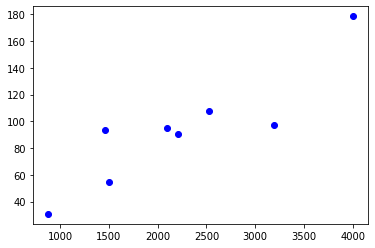

In [256]:
plt.scatter(dfC1NoDegreeAvg, dfC1AssualtAvg, c='blue')
plt.scatter(dfC2NoDegreeAvg, dfC2AssualtAvg, c='blue')
plt.scatter(dfC3NoDegreeAvg, dfC3AssualtAvg, c='blue')
plt.scatter(dfC4NoDegreeAvg, dfC4AssualtAvg, c='blue')
plt.scatter(dfC5NoDegreeAvg, dfC5AssualtAvg, c='blue')
plt.scatter(dfC6NoDegreeAvg, dfC6AssualtAvg, c='blue')
plt.scatter(dfC7NoDegreeAvg, dfC7AssualtAvg, c='blue')
plt.scatter(dfC8NoDegreeAvg, dfC8AssualtAvg, c='blue')
plt.show()

In [258]:
mapClusterWithStations = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, neighbourhood, cluster, avg, education in zip(dfAll['Latitude'], dfAll['Longitude'], dfAll['Neighbourhood'], dfAll['Cluster_Labels'], dfAll['properties.Assault_AVG'], dfAll["__No_certificate_diploma_or_degree"]):
    label = folium.Popup('Cluster:' + str(cluster) +"\n" + "neighbourhood:" + str(neighbourhood) +"\n" + "assualt avg:" + str(avg) +"\n" + "education:" + str(education), parse_html=True, max_width=300, max_height=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mapClusterWithStations)
    
for name, latitude, longitude in zip(dfStations['name'], dfStations['geocodes.main.latitude'], dfStations['geocodes.main.longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [latitude,longitude],
    radius=5,
    popup=label,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    parse_html=False).add_to(mapClusterWithStations)
       
mapClusterWithStations